In [7]:
import pandas as pd
import numpy as np

df1=pd.read_csv( r"C:\Users\User\Documents\GitHub\credit-risk-sentiment-nps\data\official\attrited_only_voluntary_personal_sentiment_nps_sample.csv", encoding='ISO-8859-1')

dfinvol=pd.read_csv( r"C:\Users\User\Documents\GitHub\credit-risk-sentiment-nps\data\official\attrited_only_involuntary_business_sentiment_nps_sample.csv", encoding='ISO-8859-1')

df1.rename(columns={
    "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1": "NB_Attrition_Prob_Yes",
    "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2": "NB_Attrition_Prob_No"
}, inplace=True)

df2= pd.read_csv( r"C:\Users\User\Documents\GitHub\credit-risk-sentiment-nps\data\official\credit_risk_after_data_cleansing.csv")

In [9]:
column_names = df2.columns.tolist()
# print(column_names)

df = pd.merge(
    df1[['CLIENTNUM', 'review', 'date','City']],
    df2[['CLIENTNUM', 'Attrition_Flag', 'Customer_Age', 'Gender', 'Dependent_count', 'Education_Level', 
         'Marital_Status', 'Income_Category', 'Card_Category', 'Months_on_book', 'Total_Relationship_Count', 
         'Months_Inactive_12_mon', 'Contacts_Count_12_mon', 'Credit_Limit', 'Total_Revolving_Bal', 'Avg_Open_To_Buy', 
         'Total_Amt_Chng_Q4_Q1', 'Total_Trans_Amt', 'Total_Trans_Ct', 'Total_Ct_Chng_Q4_Q1', 'Avg_Utilization_Ratio', 
         'NB_Attrition_Prob_Yes', 'NB_Attrition_Prob_No', 'Attrition_Type', 'annual_income', 'monthly_income', 'DTI_ratio', 
         'DTI_Risk_Level', 'Credit_Score', 'Loan_Default_Flag', 'Number_of_Defaults', 'Last_Default_Date', 'Default_Amount', 
         'Bankruptcy_History', 'Bankruptcy_Flag', 'Adjusted_Credit_Score', 'Moodys_Rating', 'Payment_History_Flag', 'Payment_Risk', 
         'Income_Category_Inferred', 'Income_Category_Complete','estimated_annual_revenue']],
    on='CLIENTNUM',
    how='inner'
)

In [10]:
# 🤖 3. Load Hugging Face Sentiment Model
from transformers import pipeline

# Load sentiment analysis pipeline
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model="distilbert/distilbert-base-uncased-finetuned-sst-2-english"
)

# Apply the sentiment model to each review
df['sentiment_result'] = df['review'].apply(lambda x: sentiment_pipeline(x)[0])

# Split the result into label and score
df['sentiment_label'] = df['sentiment_result'].apply(lambda x: x['label'])
df['sentiment_score'] = df['sentiment_result'].apply(lambda x: x['score'])
# Simple mapping: +1 for POSITIVE, -1 for NEGATIVE
df['sentiment_numeric'] = df['sentiment_label'].map({'POSITIVE': 1, 'NEGATIVE': -1}) * df['sentiment_score']

Device set to use cpu


In [11]:
print(df[['review', 'sentiment_label', 'sentiment_score','sentiment_numeric']])

                                                review sentiment_label  \
0    Unable to make a payment from another credit c...        NEGATIVE   
1    went on the phone talk to 3 different people a...        NEGATIVE   
2    I have had an argos card for years and have ne...        NEGATIVE   
3    They wrote to say they suspended my account ca...        NEGATIVE   
4    I Spoke with them twice this week both times t...        NEGATIVE   
..                                                 ...             ...   
512                                    NOT GOOD ENOUGH        NEGATIVE   
513                              Lack of communication        NEGATIVE   
514  I have purchased something by Argos card and h...        NEGATIVE   
515  However it is not appearing on my account and ...        NEGATIVE   
516  I then went to the Argos store and have been t...        NEGATIVE   

     sentiment_score  sentiment_numeric  
0           0.999649          -0.999649  
1           0.999418       

In [12]:
import pandas as pd

# Sample review column
# df['review'] should already exist
df['review_lower'] = df['review'].str.lower()

def categorize_review(text):
    if any(keyword in text for keyword in ['rude', 'unhelpful', 'no support', 'bad service', 'customer service']):
        return 'Poor Customer Service'
    elif any(keyword in text for keyword in ['rate', 'fees', 'charges', 'expensive']):
        return 'High Rate / Fees'
    elif any(keyword in text for keyword in ['slow', 'technical', 'issue', 'problem', 'crash']):
        return 'Technical Issues'
    elif any(keyword in text for keyword in ['easy', 'great', 'love', 'satisfied', 'happy']):
        return 'Positive Experience'
    elif any(keyword in text for keyword in ['cancel', 'left', 'closed', 'terminate', 'switch']):
        return 'Attrition Intent'
    else:
        return 'Other'

# Apply function
df['category'] = df['review_lower'].apply(categorize_review)
df[['category','review']]

,category,review
0,Poor Customer Service,Unable to make a payment from another credit c...
1,Poor Customer Service,went on the phone talk to 3 different people a...
2,Technical Issues,I have had an argos card for years and have ne...
3,Technical Issues,They wrote to say they suspended my account ca...
4,Poor Customer Service,I Spoke with them twice this week both times t...
...,...,...
512,Other,NOT GOOD ENOUGH
513,Other,Lack of communication
514,Other,I have purchased something by Argos card and h...
515,Other,However it is not appearing on my account and ...


C:\Users\User\AppData\Local\Temp\ipykernel_1048\632389910.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='category',


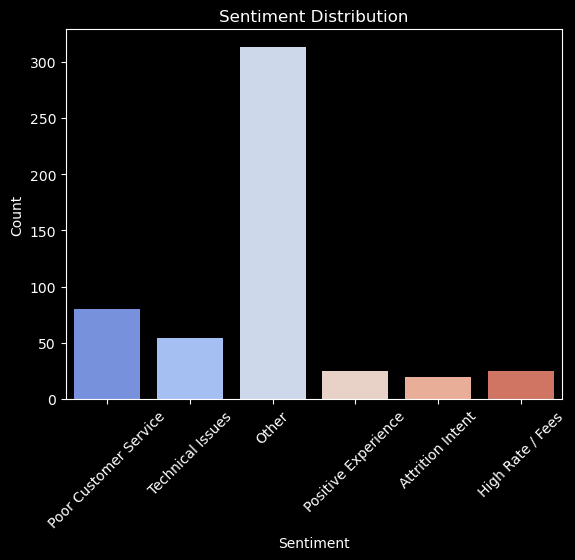

In [13]:
# ✅ 1. Basic Sentiment Distribution Plot
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.xticks(rotation=45)
sns.countplot(data=df, x='category', 
              palette='coolwarm', legend=False)
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


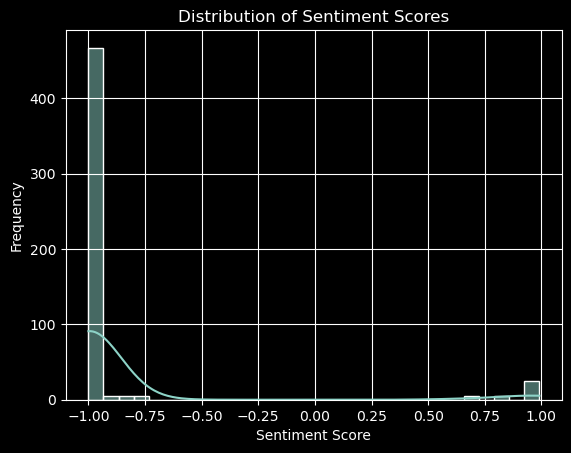

In [14]:
# ✅ 2. Sentiment Score Histogram
plt.style.use('dark_background')

sns.histplot(df['sentiment_numeric'], bins=30, kde=True)
plt.title("Distribution of Sentiment Scores")
plt.xlabel("Sentiment Score")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


In [ ]:
# NPS

# Assuming you already have a sentiment score or label
def infer_nps(sentiment_label):
    if sentiment_label.lower() == 'positive':
        return 'Promoter'
    elif sentiment_label.lower()== 'neutral':
        return 'Passive'
    elif sentiment_label.lower() == 'negative':
        return 'Detractor'
    else:
        return 'Unknown'

df['nps_category'] = df['sentiment_label'].apply(infer_nps)

nps_percentage = df['nps_category'].value_counts(normalize=True) * 100
df['nps_summary'] = df['nps_category'].map(nps_percentage)

df['nps_value'] = df['nps_summary'].get('Promoter', 0) - df['nps_summary'].get('Detractor', 0)

df[['nps_category','nps_summary','nps_value']]

# ✅ NPS Distribution Plot
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('dark_background')
plt.xticks(rotation=45)

sns.countplot(data=df, x='nps_category', hue='nps_category', palette='coolwarm', legend=False)
plt.title("Net Promoter Score Distribution for Voluntary Attrited Customers")
plt.xlabel("Net Promoter Score")
plt.ylabel("Count")
plt.show()
